# deep_5 optimal model
# deep_res resnet and big generator
# deep_res_2 resnet and small generator


In [1]:
!export CUDA_VISIBLE_DEVICES=0

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
import h5py
import tqdm
import zipfile
from tqdm.notebook import tqdm_notebook
from progress.bar import IncrementalBar
import random
import pandas as pd
import time
import os
import math
from joblib import Parallel, delayed
import importlib
# tf.config.run_functions_eagerly(True)
%matplotlib inline

In [3]:
np.set_printoptions(suppress=True)

In [4]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
cd ../src

/home/rfit/Telescope_Array/Parameters_all/src


In [6]:
import reconstruction as reco

In [7]:

param_names=['signal','pl_fr','real_wf-pl_fr','mask']


In [8]:
def norming(data,param_names=param_names,log=True):
    
    # ADD LOGARIFM FOR SIGNAL
    norm_params={}
    for i in range(data.shape[-1]):
        if (i==0 and log):
            data[:,:,:,i]=tf.math.log(data[:,:,:,i]+1)
        max_c=data[:,:,:,i].max()
        min_c=data[:,:,:,i].min()
        mean_c=data[:,:,:,i].mean()
        std_c=data[:,:,:,i].std()
        print('max_c,min_c',max_c,min_c)
        data[:,:,:,i]=(data[:,:,:,i]-min_c)/(max_c-min_c)

        norm_params[param_names[i]]=np.array([max_c,min_c])
    return norm_params

In [9]:
cd ../Notebooks/

/home/rfit/Telescope_Array/Parameters_all/Notebooks


In [10]:
#../../data_01_24.h5
path_old='../../data_01_24.h5'
path_new = '/home3/ivkhar/TA/data/MC/bundled/pr_q3_14yr_1745_0010_excl-sat_F_excl-geo_F_take-log-wf-False_bundled.h5'
path = path_new
num=-1
with h5py.File(path,'r') as f:
    print(f.keys())
    data=f['dt_bunlde'][:num,:,:,3:7]
    print(data.shape)
    detectors_rub = f['dt_bunlde'][:num,:,:,:3] * 1.2 #/ 6 # norming
    real_ang = f['mc_params'][:num,4:6]
    recos = f['recos'][:num]
    dt_params =f['dt_params'][:num]
    ev_starts = f['ev_starts'][:num]
    if path == path_new:
        dt_bunlde_mask = f['dt_bunlde_mask'][:num]
norm_params=norming(data,log=False)
theta = tf.cast(real_ang[:,0:1]/180*3.1415,tf.float32)
phi = tf.cast(real_ang[:,1:2]/180*3.1415,tf.float32)
courve  = tf.cast(recos[:,6:7],tf.float32)
S800 = tf.cast(recos[:,2:3],tf.float32)
chi_rub = tf.cast(recos[:,5:6],tf.float32)

<KeysViewHDF5 ['det_max_params', 'det_max_wf', 'dt_bunlde', 'dt_bunlde_mask', 'dt_mask', 'dt_params', 'ev_ids', 'ev_starts', 'mc_params', 'recos', 'wfs_flat']>
(173043, 6, 6, 4)
max_c,min_c 8387.6 0.0
max_c,min_c 11.0 -11.551
max_c,min_c 11.974 -7.153
max_c,min_c 1.0 0.0


In [11]:
# without flat front
path_old='../../data_01_24.h5'
path_new = '/home3/ivkhar/TA/data/MC/bundled/pr_q3_14yr_1745_0010_excl-sat_F_excl-geo_F_take-log-wf-False_bundled.h5'
path = path_new
num=-1
with h5py.File(path,'r') as f:
    print(f.keys())
    data=np.concatenate([f['dt_bunlde'][:num,:,:,3:4],f['dt_bunlde'][:num,:,:,5:7]],axis=-1)
    flat_front = f['dt_bunlde'][:num,:,:,4:5]
    data[:,:,:,1:2] += flat_front
                  
    print(data.shape)
    detectors_rub = f['dt_bunlde'][:num,:,:,:3] * 1.2 #/ 6 # norming
    real_ang = f['mc_params'][:num,4:6]
    recos = f['recos'][:num]
    dt_params =f['dt_params'][:num]
    ev_starts = f['ev_starts'][:num]
    if path == path_new:
        dt_bunlde_mask = f['dt_bunlde_mask'][:num]
norm_params=norming(data,log=False)
theta = tf.cast(real_ang[:,0:1]/180*3.1415,tf.float32)
phi = tf.cast(real_ang[:,1:2]/180*3.1415,tf.float32)
courve  = tf.cast(recos[:,6:7],tf.float32)
S800 = tf.cast(recos[:,2:3],tf.float32)
chi_rub = tf.cast(recos[:,5:6],tf.float32)

<KeysViewHDF5 ['det_max_params', 'det_max_wf', 'dt_bunlde', 'dt_bunlde_mask', 'dt_mask', 'dt_params', 'ev_ids', 'ev_starts', 'mc_params', 'recos', 'wfs_flat']>
(173043, 6, 6, 3)
max_c,min_c 8387.6 0.0
max_c,min_c 13.029 -8.804
max_c,min_c 1.0 0.0


In [12]:
ind = tf.where(real_ang[:,0]>20)[:,0]
data = tf.gather(data,ind)
detectors_rub = tf.gather(detectors_rub,ind)
dt_bunlde_mask  = tf.gather(dt_bunlde_mask,ind)
data.shape,ind.shape,detectors_rub.shape,dt_bunlde_mask.shape


(TensorShape([150604, 6, 6, 3]),
 TensorShape([150604]),
 TensorShape([150604, 6, 6, 3]),
 TensorShape([150604, 6, 6, 2]))

In [13]:
# tf.random.shuffle(data)
n=int(0.9*len(data))
train = data[:n]
test =data[n:]
detectors_rub = detectors_rub[:n]
dt_bunlde_mask =dt_bunlde_mask[:n]
print(train.shape,detectors_rub.shape,dt_bunlde_mask.shape)
# detectors_rub_train = detectors_rub[]

(135543, 6, 6, 3) (135543, 6, 6, 3) (135543, 6, 6, 2)


In [14]:
def renorming(data,norm_params):
    val=np.array(list(norm_params.values()))
    max_c=val[:,0]
    min_c=val[:,1]
    data = data*(max_c-min_c) + min_c
#     if (i==0 and log):
#         data = data[:,:,:,i].assign(tf.math.exp(data[:,:,:,i])-1)
#     #         elif (i==1 or i==2):
#     #             data[:,:,:,i]=data[:,:,:,i]#*1e6
    return data

In [15]:
#TODO

# Отловить место где появляются наны. 
# подкрутить паарметр адама,чтобы он меньше запоминал историю 
# clip norm, global clip norm, Nadam, change beta
# write grad
# посмотреть разницу между файлами
# посмотреть почему на S800 мы где то расходимся а где-то нет
# проверить аномальные результаты
# проверить коректность S800

In [16]:
def norming_params(param):
    t = tf.reduce_max(param)
    b = tf.reduce_min(param)
    param = (param-b)/(t-b)
    return param,t,b
def renorm_params(param,p_t,p_b):
    return param*(p_t-p_b)+p_b

In [17]:
# theta,theta_t,theta_b = norming_params(theta)
# phi,phi_t,phi_b = norming_params(phi)
# courve,courve_t,courve_b = norming_params(courve)
# S800,S800_t,S800_b = norming_params(S800) 
# theta.dtype,theta_t,theta_b 

In [18]:
# all_data = list(zip(data,detectors_rub,theta,phi,courve,S800))
# random.shuffle(all_data)
# train = all_data[:172000]
# test = all_data[172000:]
# print(len(train),len(test))

In [19]:
reco

<module 'reconstruction' from '/home/rfit/Telescope_Array/Parameters_all/src/reconstruction.py'>

In [20]:
import imp

# Optimization params of shower

In [21]:
cd ../src

/home/rfit/Telescope_Array/Parameters_all/src


In [22]:
imp.reload(reco)

<module 'reconstruction' from '/home/rfit/Telescope_Array/Parameters_all/src/reconstruction.py'>

In [23]:
# step = tf.Variable(0, trainable=False)
boundaries = [1000]
values = [ 0.0001,  0.0001/5]
learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)


In [24]:
#old mask
boundaries = [300]
values = [ 0.001,  0.001/5]
learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)
imp.reload(reco)
# chi_list, params_list = reco.optimization_2(train,iterats=500,num=None,
#                                           detectors_rub=detectors_rub,
#                                           add_mask = dt_bunlde_mask,
#                                           use_L = False,
#                                           use_core =False,
# #                                           S800_rub=S800,
#                                           optim_name="SGD",l_r =learning_rate_fn,
# #                                           use_L3=False,
#                                             find_core=True,
#                                          )
# plt.plot(tf.math.abs(params_list[-1,:,1]*180/3.1415),theta[:,0]*180/3.1415,'b.',label='our')
# plt.plot(recos[:,0],theta[:,0]*180/3.1415,'g.',label='rub')
# plt.plot([20,90],[20,90],'r--')
# plt.legend()
# plt.xlabel('real')
# plt.ylabel('recon')
# plt.title('Theta')

<module 'reconstruction' from '/home/rfit/Telescope_Array/Parameters_all/src/reconstruction.py'>

# Обучение Нейронки

In [25]:
noise_dim=50
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0, beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0, beta_2=0.9)

In [26]:
# ep=199
# # generator=tf.keras.models.load_model('../Models/deep_5/save_model/generator/ep'+str(100))
# discriminator=tf.keras.models.load_model('../Models/deep_5/save_model/discriminator/ep'+str(100))
# # noise = tf.random.normal(shape=(100,50))
# # fake_data=generator(noise)#change
# # print(tf.math.reduce_mean(discriminator(fake_data)))

# # print(tf.math.reduce_mean(discriminator(data[-100:])))

In [27]:
# def Conditional_generator(generator,num="",noise_dim=50):
#     input_noise=tf.keras.Input(shape=(noise_dim,))
#     input_detectors = tf.keras.Input(shape=(6,6,3)) # don't use like input generator
#     input_core = det2core(input_detectors)
#     input_theta = tf.keras.Input(shape=(1,))
#     input_phi = tf.keras.Input(shape=(1,))
#     input_courve =tf.keras.Input(shape=(1,))
#     input_S800 =  tf.keras.Input(shape=(1,))
    
#     input_tensor = tf.keras.layers.concatenate([input_noise,input_core,input_theta,input_phi,input_courve,input_S800])
#     noise = tf.keras.layers.Dense(noise_dim)(input_tensor)
#     result = generator(noise)
#     model= tf.keras.Model([input_noise,input_detectors,input_theta,input_phi,input_courve,input_S800],
#                           result,
#                           name="Generator_model_{}".format(num))
#     return model
# cond_generator = Conditional_generator(tf.keras.models.load_model('../Models/deep_5/save_model/generator/ep'+str(100)))
# cond_generator.summary()

# TRAIN NOT CONDITIONAL

In [28]:
generator=tf.keras.models.load_model('../Models/3_chanals/save_model/generator/ep'+str(150))
discriminator=tf.keras.models.load_model('../Models/3_chanals/save_model/discriminator/ep'+str(150))

In [28]:
generator.layers[-3].filters = 3#tf.keras.layers.Conv2D(3, (1, 1))
generator = tf.keras.models.model_from_json(generator.to_json())
generator.summary()

Model: "Generator_model_"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               25600     
_________________________________________________________________
batch_normalization_24 (Batc (None, 512)               2048      
_________________________________________________________________
tf.nn.gelu_24 (TFOpLambda)   (None, 512)               0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 4, 4, 32)          0         
_________________________________________________________________
C_0 (Conv2D)                 (None, 4, 4, 32)          4096      
_________________________________________________________________
batch_normalization_25 (Batc (None, 4, 4, 32)     

In [29]:
discriminator.summary()

Model: "Discriminator_model_num_"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 6, 6, 4)]         0         
_________________________________________________________________
first (Conv2D)               (None, 6, 6, 16)          592       
_________________________________________________________________
tf.nn.gelu_30 (TFOpLambda)   (None, 6, 6, 16)          0         
_________________________________________________________________
second (Conv2D)              (None, 3, 3, 32)          4640      
_________________________________________________________________
tf.nn.gelu_31 (TFOpLambda)   (None, 3, 3, 32)          0         
_________________________________________________________________
therd (Conv2D)               (None, 3, 3, 32)          9248      
_________________________________________________________________
tf.nn.gelu_32 (TFOpLambda)   (None, 3, 3, 

In [30]:
new_input = tf.keras.Input((6,6,3))
# discriminator.layers[1] = tf.keras.layers.Conv2D(16, (3, 3))
# discriminator = tf.keras.models.model_from_json(discriminator.to_json())
x = tf.keras.layers.Conv2D(16, (1, 1))(new_input) # First conv. layer

for new_layer in discriminator.layers[2:]:
    x = new_layer(x) # loop through layers using Functional API
discriminator = tf.keras.Model(inputs=new_input, outputs=x)

discriminator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 6, 3)]         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 6, 6, 16)          64        
_________________________________________________________________
tf.nn.gelu_30 (TFOpLambda)   (None, 6, 6, 16)          0         
_________________________________________________________________
second (Conv2D)              (None, 3, 3, 32)          4640      
_________________________________________________________________
tf.nn.gelu_31 (TFOpLambda)   (None, 3, 3, 32)          0         
_________________________________________________________________
therd (Conv2D)               (None, 3, 3, 32)          9248      
_________________________________________________________________
tf.nn.gelu_32 (TFOpLambda)   (None, 3, 3, 32)          0     

In [31]:
# theta,theta_t,theta_b = norming_params(theta)
# phi,phi_t,phi_b = norming_params(phi)
# courve,courve_t,courve_b = norming_params(courve)
# S800,S800_t,S800_b = norming_params(S800) 
# theta.dtype,theta_t,theta_b 

In [29]:
def im_one(i,data,axs):
    signal=data[i,:,:,0]
    real_time=data[i,:,:,1]+data[i,:,:,2]
    mask=data[i,:,:,3]
    sns.heatmap(data[i,:,:,0]*mask,annot=data[i,:,:,0]*mask,ax=axs[i,0],vmin=0.0, vmax=1.0)
    sns.heatmap(real_time*mask,annot=real_time*mask,ax=axs[i,1],vmin=-1.0, vmax=1.0)

def image_signal(data,fake=None,dir_name=None,ep='not_ep'):
    n=data.shape[0]
    if (fake is None):
        fig, axs = plt.subplots(nrows=n, ncols=2, figsize=(10,n*5))
#         Parallel(n_jobs=-1)(delayed(im_one)(i,data,axs) for i in range(n))
        for i in range(n):
            im_one(i,data,axs)
            axs[i,0].set_title(f'number {str(i)}')
                           
        fig.suptitle('only real')
    else:
        fig, axs = plt.subplots(nrows=n, ncols=4, figsize=(10*2,n*5))
        data_after = renorming(data,norm_params)
        data_after = tf.where(tf.cast(tf.expand_dims(data_after[:,:,:,-1],axis=-1),tf.bool),data_after[:,:,:,:],np.nan)
        fake_after = renorming(fake,norm_params)
        fake_mask = tf.cast(tf.where(tf.cast(fake_after[:,:,:,2:3]>0.5,tf.bool),1,0),tf.float32)
        fake_after *= fake_mask
        fake_after = tf.where(tf.cast(tf.expand_dims(fake_after[:,:,:,-1],axis=-1),tf.bool),fake_after[:,:,:,:],np.nan)
        for i in range(n):
            sns.heatmap(data_after[i,:,:,0],annot=data_after[i,:,:,0],ax=axs[i,2],fmt=".1f")
            sns.heatmap(data_after[i,:,:,1],annot=data_after[i,:,:,1],ax=axs[i,3],fmt=".2f")
            
            
            sns.heatmap(fake_after[i,:,:,0],annot=fake_after[i,:,:,0],ax=axs[i,0],fmt=".1f")
            sns.heatmap(fake_after[i,:,:,1],annot=fake_after[i,:,:,1],ax=axs[i,1],fmt=".2f")
        fig.suptitle('fake     /    real')
    if dir_name:
        plt.savefig("{}/save_images/epoch{}.png".format(dir_name,ep))
        plt.close()
        
def images(cond_generator,num, data_all,
           noise_dim=noise_dim, dir_name='', ep='not_ep'):
    shape = (6,6,3)
    rand=np.random.choice(np.arange(len(data_all)),num)
    data_for_plot=np.zeros((num,shape[0],shape[1],shape[2]))
#     det_l = np.zeros((num,6,6,3))
#     theta_l = np.zeros((num,1))
#     phi_l = np.zeros((num,1))
#     courve_l = np.zeros((num,1))
#     S800_l = np.zeros((num,1))
    for i in range(num):
#         data, det, theta, phi, courve, S800 = data_all[rand[i]]
        data = data_all[rand[i]]
#         print(data.shape, det, theta, phi, courve, S800)
        data_for_plot[i]=data
#         det_l[i] = det
#         theta_l[i] = theta
#         phi_l[i] = phi
#         courve_l[i] = courve
#         S800_l[i] = S800
    noise = tf.random.normal(shape=(num,noise_dim))
#     fake=cond_generator([noise,det_l, theta_l, phi_l, courve_l,S800_l])
    fake=generator(noise)
    fake = np.array(fake)
    image_signal(data_for_plot,fake=fake,dir_name=dir_name,ep=ep)

In [30]:
# images(cond_generator,2, test)

In [31]:
def discriminator_loss(real_output, fake_output):
    real_loss = -tf.reduce_mean(real_output)
    fake_loss = tf.reduce_mean(fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def reco_loss(data,detectors_rub,dt_bunlde_mask,learning_rate_fn,norm_params):
    data_ = renorming(data,norm_params)
    chi_list, params_list = reco.optimization_2(data_,iterats=500,num=None,
                                          detectors_rub=detectors_rub,
                                          add_mask = dt_bunlde_mask,
                                          use_L = False,
                                          use_core =False,
#                                           S800_rub=S800,
                                          optim_name="SGD",l_r =learning_rate_fn,
#                                           use_L3=False,
                                            find_core=False, flat_chanal  = False,
                                         )
    return chi_list[:,0]
def loss_time(data,kof=10,res=tf.Variable(0,dtype=tf.float32)):
#     res=tf.Variable(0,dtype=tf.float32)
    for i in range(data.shape[0]):
        data_n=tf.where(tf.cast(tf.expand_dims(data[i,:,:,-1],axis=-1),tf.bool),data[i],np.nan)
        arg=tf.where(data_n[:,:,0] == tf.math.reduce_max(data[i,:,:,0]))[0]
        time=data_n[arg[0],arg[1],2]
        min_time=tf.math.reduce_min(tf.where(tf.math.is_nan(data_n[:,:,2]),np.inf,data_n[:,:,2]))
        res=res+time-min_time
    return(res/data.shape[0]*kof)
        
#     max_active_time=
def generator_loss(fake_output):
#     return loss_function(tf.ones_like(fake_output), fake_output)
    return -tf.reduce_mean(fake_output)

def gradient_penalti(batch,real_data,fake_data):
#   alpha = tf.random.normal([batch, 1], 0.0, 1.0)
#   diff = fake_data - real_data
#   interpolated = real_data + alpha * diff
    epsilon=tf.random.uniform(shape=(batch,1,1,1),dtype=tf.dtypes.float32)
#     print(epsilon)
    interpolated=real_data-epsilon*(real_data-fake_data)# вычисление x^ как в статье
    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        pred=discriminator(interpolated,training=True)  # D(x^)
    grads = gp_tape.gradient(pred, [interpolated])[0]# because list
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp    
# @tf.function
def train_step_WGAN(labda,batch,real_data,weight_gp,detectors_rub,dt_bunlde_mask):
  # labda --> number learling critic
  #weight --> weight gradient_penalti

  #learning critic
    real_time = real_data[:,:,:,1:2] +real_data[:,:,:,2:3]
    mask = real_data[:,:,:,3:4]
    t0=tf.constant(0, dtype=tf.float32)
    for i in range(labda):
        with tf.GradientTape() as gr:
            noise = tf.random.normal(shape=(batch,noise_dim))
            fake_data=generator(noise)
            real_data=real_data
            fake_predict=discriminator(fake_data)
            real_predict=discriminator(real_data)
            real_data=tf.cast(real_data,dtype=tf.float32)
            gp=gradient_penalti(batch,real_data,fake_data)
            disc_loss=discriminator_loss(real_predict,fake_predict)+weight_gp*gp
        d_grad=gr.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(d_grad, discriminator.trainable_variables))
  #learning generator
    noise = tf.random.normal(shape=(batch,noise_dim))
    with tf.GradientTape() as gr:
        fake_data=generator(noise)
        fake_predict=discriminator(fake_data)
        gen_loss=generator_loss(fake_predict)
        tf.config.run_functions_eagerly(False)
#         with tf.device("cpu"):
        reco_loss_val = reco_loss(fake_data,detectors_rub,dt_bunlde_mask,learning_rate_fn,norm_params)
#         time_loss_val = loss_time(fake_data)
        tf.config.run_functions_eagerly(True)
        gen_loss+= reco_loss_val #+ time_loss_val
    g_grad=gr.gradient(gen_loss,generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(g_grad, generator.trainable_variables))
    return (gen_loss,disc_loss,None,reco_loss_val)#,time_loss_val,reco_loss_val)
@tf.function
def train_step_COND_WGAN(real_data, detectors, t0, theta, phi, courve, S800,
                         batch,labda=5,weight_gp=10):
  # labda --> number learling critic
  #weight --> weight gradient_penalti

  #learning critic
    real_time = real_data[:,:,:,1:2] +real_data[:,:,:,2:3]
    mask = real_data[:,:,:,3:4]
    t0=tf.constant(0, dtype=tf.float32)
    for i in tf.range(labda):
        with tf.GradientTape() as gr:
            noise = tf.random.normal(shape=(batch,noise_dim))
            fake_data=cond_generator([noise,detectors, theta, phi, courve,S800])#change
#             print('f')
            real_data=real_data
            fake_predict=discriminator(fake_data)
            real_predict=discriminator(real_data)
            real_data=tf.cast(real_data,dtype=tf.float32)
            gp=gradient_penalti(batch,real_data,fake_data)
            disc_loss=discriminator_loss(real_predict,fake_predict)+weight_gp*gp # critic loss include GP
        d_grad=gr.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(d_grad, discriminator.trainable_variables))
  #learning generator
    noise = tf.random.normal(shape=(batch,noise_dim))
    with tf.GradientTape() as gr:
        fake_data=cond_generator([noise,detectors, theta, phi, courve,S800])
        fake_predict=discriminator(fake_data)
        
        gen_loss=generator_loss(fake_predict)
        gen_loss=gen_loss+ loss_time(fake_data)
        
        fake_data_renorm = renorming(fake_data,log=False)
        fake_time= fake_data_renorm[:,:,:,1:2] +fake_data_renorm[:,:,:,2:3]
        #renorming
        theta = renorm_params(theta,theta_t,theta_b)
        phi = renorm_params(phi,phi_t,phi_b)
        courve = renorm_params(courve,courve_t,courve_b)
        S800 = renorm_params(S800,S800_t,S800_b)
        
        gen_loss=gen_loss+ reco_loss(fake_time, detectors*6,t0,theta,phi,courve,mask,S800)
        
    g_grad=gr.gradient(gen_loss,cond_generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(g_grad, cond_generator.trainable_variables))
    return (gen_loss,disc_loss)
def func_chunks_generators(lst, n):
    '''передается масив и число.масив разбивается на масивы длиной не более n
    пример func_chunks_generators([1,2,3,4,5], 3) -> [[1,2,3],[4,5]]
    lst- масив
    n- число, пределяющее максимальную длину'''
    l=[]
    for i in range(0, len(lst), n):
         l.append(lst[i : i + n])
    return(l)

In [32]:
imp.reload(reco)

<module 'reconstruction' from '/home/rfit/Telescope_Array/Parameters_all/src/reconstruction.py'>

In [33]:
train.shape,detectors_rub.shape, dt_bunlde_mask.shape

(TensorShape([135543, 6, 6, 3]),
 TensorShape([135543, 6, 6, 3]),
 TensorShape([135543, 6, 6, 2]))

In [ ]:
batch=500
epochs=100
ep_start=0
g_list=[]
d_list=[]
time_list=[]
r_list=[]
def train_WGAN(epochs,train_data,test_data,batch,dir_name,
               detectors_rub,
              ):
    lamda = tf.constant(5,dtype=tf.float32)
    weight_gp = tf.constant(10,dtype=tf.float32)
    if not(os.path.exists(dir_name)):
        os.mkdir(dir_name)
        os.mkdir(os.path.join(dir_name,'save_images'))
        os.mkdir(os.path.join(dir_name,'save_model'))
        os.mkdir(os.path.join(dir_name,'save_model/discriminator'))
        os.mkdir(os.path.join(dir_name,'save_model/generator'))
    train_data = func_chunks_generators(train_data, batch)
    detectors_rub_step = func_chunks_generators(detectors_rub, batch)
    dt_bunlde_mask_step = func_chunks_generators(dt_bunlde_mask, batch)
    print(len(train_data),len(detectors_rub_step),len(dt_bunlde_mask_step))
    for j in tqdm_notebook(range(ep_start,epochs),'ep'):
        # обрубание последнего батча. Испраивить 
        for num in tqdm_notebook(range(0,len(train_data)-1),f'epoch num{j}'):
            step_data=tf.Variable(train_data[num],dtype = tf.float32)
            g,d,t,r=train_step_WGAN(5, batch, step_data, weight_gp,detectors_rub_step[num],dt_bunlde_mask_step[num])
            d_list.append(d)
            g_list.append(g)
            time_list.append(t)
            r_list.append(r)
#         if (j % 10 == 0):
        images(generator,num=10, data_all=test_data,
               noise_dim=noise_dim,dir_name=dir_name,ep=j)
        discriminator.save("{}/save_model/discriminator/ep{}".format(dir_name,j))
        generator.save("{}/save_model/generator/ep{}".format(dir_name,j))
        plt.close()
dir_name = '../Models/3_chanals_phyloss'
train_WGAN(epochs,train,test,batch,dir_name=dir_name,detectors_rub=detectors_rub)

plt.close()
plt.figure()
plt.plot(d_list[5000::100],'r')
plt.plot(g_list[5000::100],'g')
plt.plot(time_list[5000::100],'b')
plt.legend(['disc','gen'])
# plt.ylim(-5,5)
plt.title(dir_name)
plt.savefig(os.path.join(dir_name,'loss.jpg'))
df=pd.DataFrame({'disc':d_list,'gen':g_list,"time":time_list})
df.to_csv("{}/loss.csv".format(dir_name))

272 272 272



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



/home/rfit/.conda/envs/robert_venv/lib/python3.6/site-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/rfit/.conda/envs/robert_venv/lib/python3.6/site-packages/seaborn/matrix.py:208: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


INFO:tensorflow:Assets written to: ../Models/3_chanals_phyloss/save_model/discriminator/ep0/assets
INFO:tensorflow:Assets written to: ../Models/3_chanals_phyloss/save_model/generator/ep0/assets



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



/home/rfit/.conda/envs/robert_venv/lib/python3.6/site-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/rfit/.conda/envs/robert_venv/lib/python3.6/site-packages/seaborn/matrix.py:208: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


INFO:tensorflow:Assets written to: ../Models/3_chanals_phyloss/save_model/discriminator/ep1/assets
INFO:tensorflow:Assets written to: ../Models/3_chanals_phyloss/save_model/generator/ep1/assets



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



/home/rfit/.conda/envs/robert_venv/lib/python3.6/site-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/rfit/.conda/envs/robert_venv/lib/python3.6/site-packages/seaborn/matrix.py:208: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


INFO:tensorflow:Assets written to: ../Models/3_chanals_phyloss/save_model/discriminator/ep2/assets
INFO:tensorflow:Assets written to: ../Models/3_chanals_phyloss/save_model/generator/ep2/assets



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



/home/rfit/.conda/envs/robert_venv/lib/python3.6/site-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/rfit/.conda/envs/robert_venv/lib/python3.6/site-packages/seaborn/matrix.py:208: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


INFO:tensorflow:Assets written to: ../Models/3_chanals_phyloss/save_model/discriminator/ep3/assets
INFO:tensorflow:Assets written to: ../Models/3_chanals_phyloss/save_model/generator/ep3/assets



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



/home/rfit/.conda/envs/robert_venv/lib/python3.6/site-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/rfit/.conda/envs/robert_venv/lib/python3.6/site-packages/seaborn/matrix.py:208: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


INFO:tensorflow:Assets written to: ../Models/3_chanals_phyloss/save_model/discriminator/ep4/assets
INFO:tensorflow:Assets written to: ../Models/3_chanals_phyloss/save_model/generator/ep4/assets



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)



(500, 1)


Text(0.5, 1.0, '../Models/Conditional+Phys_loss')

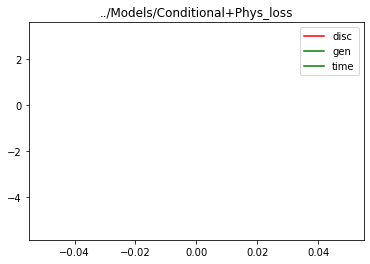

In [145]:
plt.figure()
plt.plot(d_list,'r')
plt.plot(g_list,'g')
# plt.plot(time_list[5000::100],'b')
plt.legend(['disc','gen','time'])
# plt.ylim(-5,5)
plt.title(dir_name)
# plt.savefig(os.path.join(dir_name,'loss.jpg'))

In [41]:
df=pd.DataFrame({'disc':d_list,'gen':g_list,"time":time_list})
df.to_csv("{}/loss.csv".format(dir_name))

Text(0.5, 1.0, 'deep_5_+loss')

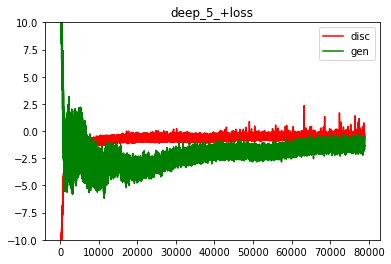

In [45]:
plt.plot(d_list,'r')
plt.plot(g_list,'g')
plt.legend(['disc','gen'])
plt.ylim(-10,10)
plt.title(dir_name)
# plt.savefig(os.path.join('deep_7_2','loss.jpg'))

Text(0.5, 1.0, 'deep_res')

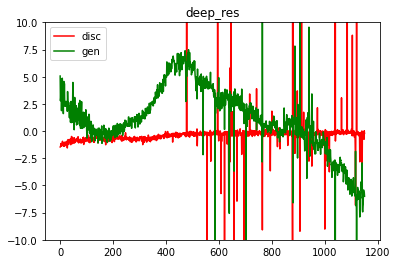

In [45]:
plt.plot(d_list[5000::100],'r')
plt.plot(g_list[5000::100],'g')
plt.legend(['disc','gen'])
plt.ylim(-10,10)
plt.title(dir_name)
# plt.savefig(os.path.join('deep_7_2','loss.jpg'))

Text(0.5, 1.0, 'deep_7')

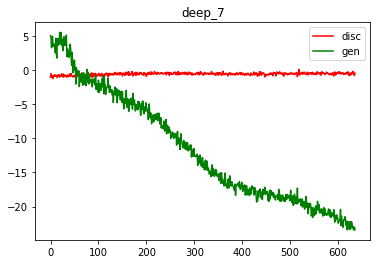

In [25]:
plt.plot(d_list[5000::100],'r')
plt.plot(g_list[5000::100],'g')
plt.legend(['disc','gen'])
# plt.ylim(-5,5)
plt.title(dir_name)

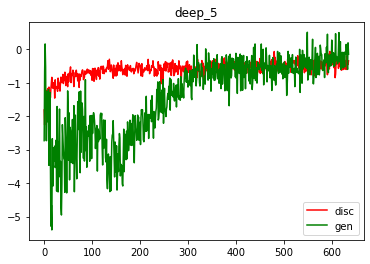

In [27]:
plt.plot(d_list[5000::100],'r')
plt.plot(g_list[5000::100],'g')
plt.legend(['disc','gen'])
# plt.ylim(-5,5)
plt.title(dir_name)
plt.savefig(os.path.join(dir_name,'loss.jpg'))

  0%|          | 8/3000 [00:00<01:36, 30.86it/s]


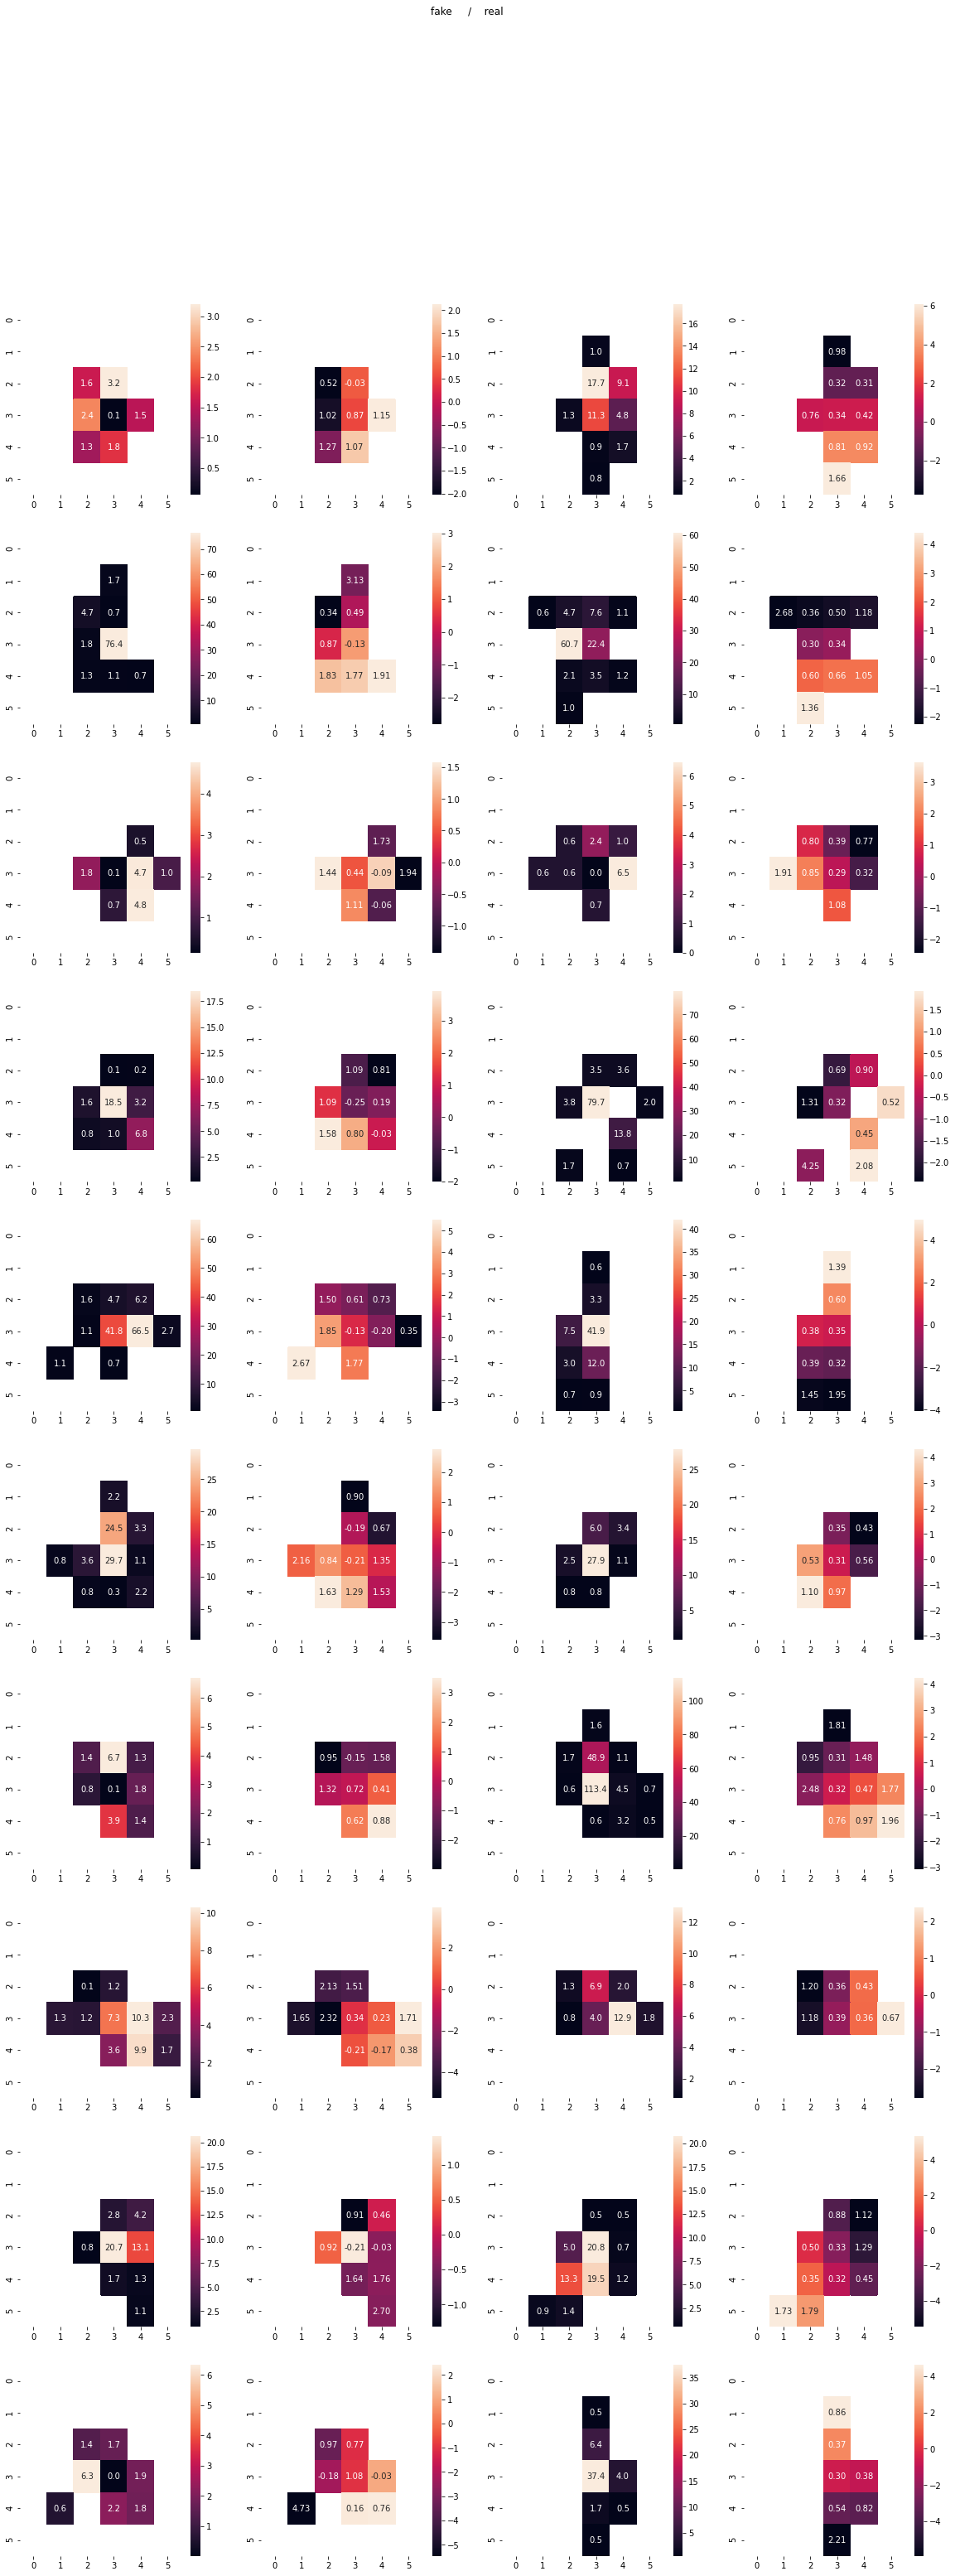

In [30]:
ep=199
generator=tf.keras.models.load_model('deep_5/save_model/generator/ep'+str(ep))
discriminator=tf.keras.models.load_model('deep_5/save_model/discriminator/ep'+str(ep))
def Residual_loss(data_true, data_fake):
    return tf.reduce_mean( tf.math.abs(data_true - data_fake),axis=(1,2,3))# сделать универсально
def Discriminator_loss(data_true, data_fake,discriminator):
    real_pred=discriminator(data_true)
    fake_pred=discriminator(data_fake)
    return tf.math.abs( real_pred - fake_pred)
loss_L=[]
def find_noise(generator,discriminator,image,noise_dim,alpha=1.2,k_rd=0.0001):
#         global loss_L
#     print(image.sha)
    global loss_L
    loss_befor=1000000000
    k=0
    noise = tf.random.normal(shape=(image.shape[0],noise_dim))
    noise_befor=tf.identity(noise)
    for i in tqdm.tqdm(range(3000)):
        with tf.GradientTape() as tape:
            tape.watch(noise)
            fake=generator(noise)
            loss=Residual_loss(image, fake)
            loss_disc=Discriminator_loss(image, fake,discriminator)*k_rd
            Loss=tf.reshape(loss,(-1,1))+loss_disc
            loss_L.append(Loss)
        g_grad=tape.gradient(Loss,noise)
        noise=noise-alpha*g_grad
        if tf.math.reduce_mean((loss_befor-Loss))<0.005*tf.math.reduce_mean(Loss):
            k+=1
            if k>7:
                break
        else:
            loss_befor=Loss
            k=0
            
    return (noise,noise_befor)
def images_define(generator,num=10,data=data,noise_dim=noise_dim,dir_name='',ep='not_ep'):
    rand=np.random.choice(np.arange(data.shape[0]),num)
    data_for_plot=np.zeros((num,shape[0],shape[1],shape[2]))
    fake=np.zeros((num,shape[0],shape[1],shape[2]))
    for i in range(num):
        data_for_plot[i]=data[rand[i]]
        noise = find_noise(generator,discriminator,np.array([data_for_plot[i]]),noise_dim,alpha=1.2,k_rd=0.0001)[0]
        fake[i]=generator(noise)
    image_signal(data_for_plot,fake=fake,dir_name=dir_name,ep=ep)

images_define(generator,num=10,data=data,noise_dim=noise_dim,dir_name='',ep='not_ep')
